# Playing Around With Trees

In [45]:
from sklearn.model_selection import KFold
from data_pre_processing.fetch_data import *
from sklearn.tree import DecisionTreeRegressor
from data_pre_processing.fill_missing_values import fill_ratings_with_mean_per_user
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import t

In [46]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.power(np.subtract(y_hat,y), 2)))

## Get Data:

In [47]:
X, y = get_X_Y_train()
X, _ = fill_ratings_with_mean_per_user(X)
X = X[:,1,:] # only ratings

## Perform Cross Validation

In [48]:
models = {
    "small" : DecisionTreeRegressor(max_depth=3, random_state=0),
    "large" : DecisionTreeRegressor(random_state=0),
    "large_pruned" : DecisionTreeRegressor(min_samples_leaf=100, random_state=0),
    "rf_small" : RandomForestRegressor(max_features = 30, max_depth=3, random_state=0, n_estimators=100),
    "rf_large" : RandomForestRegressor(max_features = 30, random_state=0, n_estimators=100)
}

scores = { key: [] for key, _ in models.items() }

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        current_score = rmse(model.predict(X_test), y_test)
        print("{} -- {}".format(model_name, current_score))
        scores[model_name].append(current_score)

print(scores)

small -- 0.8122594421524214
large -- 1.1155716023635596
large_pruned -- 0.7958779283501752
rf_small -- 0.7875195177115859
rf_large -- 0.7631778626244343
small -- 0.8345623681754037
large -- 1.1242775458044156
large_pruned -- 0.812439946519464
rf_small -- 0.7987298677667265
rf_large -- 0.7721556514071499
small -- 0.8267287036029538
large -- 1.131370849898476
large_pruned -- 0.8144129568927803
rf_small -- 0.7990754350527434
rf_large -- 0.7698122823130324
small -- 0.8212372478910599
large -- 1.0943034314119644
large_pruned -- 0.7993581889296395
rf_small -- 0.7968815854936185
rf_large -- 0.7682234050066427
small -- 0.8376320449037387
large -- 1.1024971655292362
large_pruned -- 0.8210742729991203
rf_small -- 0.8124779391429564
rf_large -- 0.7907512567173068
{'small': [0.8122594421524214, 0.8345623681754037, 0.8267287036029538, 0.8212372478910599, 0.8376320449037387], 'large': [1.1155716023635596, 1.1242775458044156, 1.131370849898476, 1.0943034314119644, 1.1024971655292362], 'large_pruned':

## plotting results:

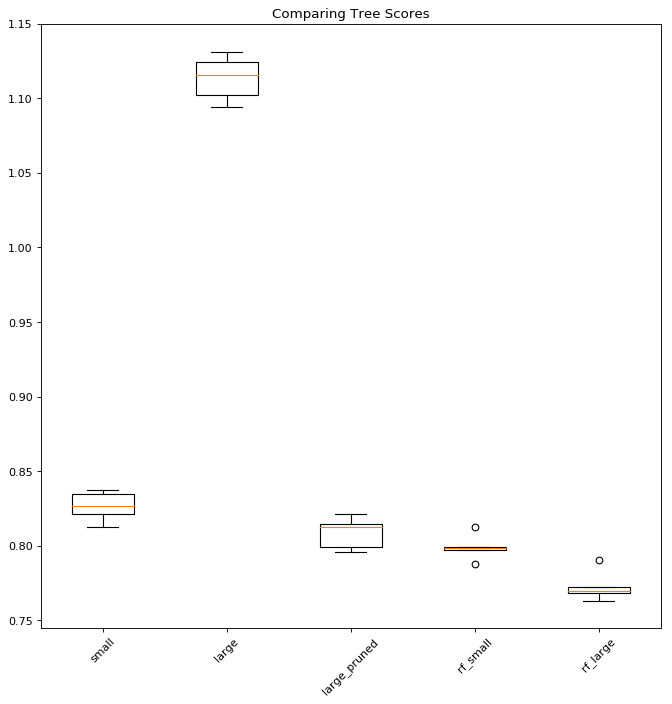

In [49]:
from matplotlib.pyplot import figure
data = [scores[model_name] for model_name, _ in models.items()]
labels = [model_name for model_name, _ in models.items()]


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Comparing Tree Scores")
plt.boxplot(data, labels=labels)
plt.xticks(rotation=45)
plt.show()

## Compute confidence intervals based on CV results:

In [52]:
data = [scores[model_name] for model_name, _ in models.items()]
headers = [model_name for model_name, _ in models.items()]

n = 5
means = [np.mean(scores) for scores in data]
stds = [np.std(scores) for scores in data]

critical_t_score = t.interval(0.95, n-1)[1]

top = ["Top"]
center = ["Center"]
bottom = ["Bottom"]
ranges = ["Interval Length"]
for i in range(n):
    center.append(means[i])
    top.append(means[i] + (1/np.sqrt(n))*critical_t_score*stds[i])
    bottom.append(means[i] - (1/np.sqrt(n))*critical_t_score*stds[i])
    ranges.append(top[-1] - bottom[-1])


rows = [headers, top, center, bottom, ranges]
print(tabulate(rows, headers="firstrow", tablefmt="latex"), sep=' ', end='', flush=True)

\begin{tabular}{lrrrrr}
\hline
                 &     small &     large &   large\_pruned &   rf\_small &   rf\_large \\
\hline
 Top             & 0.837857  & 1.13053   &      0.82043   &  0.808839  &  0.784539  \\
 Center          & 0.826484  & 1.1136    &      0.808633  &  0.798937  &  0.772824  \\
 Bottom          & 0.815111  & 1.09668   &      0.796835  &  0.789035  &  0.761109  \\
 Interval Length & 0.0227456 & 0.0338559 &      0.0235955 &  0.0198045 &  0.0234308 \\
\hline
\end{tabular}